### Imports

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    import optuna
    import torch
    from copy import deepcopy
    import os
    import matplotlib.animation as animation
    import random
    random.seed(3111)
    import h5py
    import matplotlib.pyplot as plt
    import numpy as np
    from torch.nn.functional import mse_loss
    from simulai.math.integration import LSODA, ClassWrapper
    from simulai.math.differentiation import CollocationDerivative
    from simulai.rom import POD
    from simulai.io import Reshaper
    from simulai.simulation import Pipeline
    from simulai.regression import OpInf
# Adjustment to numpy's error/warning handling for floating point operations
# np.seterr(over='raise', invalid='raise')
os.chdir(os.path.split(os.getcwd())[0]) # change directory

### Read data

In [2]:
with h5py.File(".\\dataset\\OpInfData\\standardData.h5", 'r') as f:
  # raw data is matrix with 'timestep' rows
  # and 'nodal pressure' columns
  opInfData = np.array(f["standardData"], dtype = np.float32)[:-1]
print(type(opInfData))

<class 'numpy.ndarray'>


### POD

Dimension reduction using Proper Orthogonal Decomposition

In [3]:
# Instantiating a Pipeline to prepare data
rom_config = {'n_components': 100} # new number of dimensions
pipeline = Pipeline(
  stages = [('data_preparer', Reshaper()),
  ('rom', POD(config = rom_config))]
)
# Executing the workflow
pipeline.exec(input_data = opInfData)
projectedData = pipeline.project_data(data = opInfData)
reconstructedData = pipeline.reconstruct_data(data = projectedData)
print(f"\nraw data shape: {opInfData.shape}")
print(f"projectedData shape: {projectedData.shape}")
print(f"reconstructedData shape: {reconstructedData.shape}")
print("Reconstruction MSE = {:.4e}".format(mse_loss(
    torch.tensor(reconstructedData), torch.tensor(opInfData)
).item()))

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.02489030733704567
Relative Modal Energy 0.9991124272346497
Executed operation POD.
Applying the global reconstruction strategy.

raw data shape: (1005, 3362)
projectedData shape: (1005, 100)
reconstructedData shape: (1005, 3362)
Reconstruction MSE = 7.4018e-04


### Data split
90\% used for training, and 10\% for testing

In [4]:
# timesteps
timeRange = np.arange(0, 2.5101e-2, 2.5e-5)
# augment dataset with estimates of time derivatives
diff = CollocationDerivative(config = {})
derivativeData = diff.solve(data = projectedData, x = timeRange)
# split dataset
splitIndex = np.int32(len(timeRange) * 0.9)
dataTrain = projectedData[:splitIndex]
dataTest = projectedData[splitIndex:]
dataDerivativeTrain = derivativeData[:splitIndex]
dataDerivativeTest = derivativeData[splitIndex:]
timeTrain = timeRange[:splitIndex]
timeTest = timeRange[splitIndex:]

print(f"dataTrain shape: {dataTrain.shape}")
print(f"dataTest shape: {dataTest.shape}")
print(f"dataDerivativeTrain shape: {dataDerivativeTrain.shape}")
print(f"dataDerivativeTest shape: {dataDerivativeTest.shape}")
print(f"timeTrain shape: {timeTrain.shape}")
print(f"timeTest shape: {timeTest.shape}")

Performing Collocation Derivation.
dataTrain shape: (904, 100)
dataTest shape: (101, 100)
dataDerivativeTrain shape: (904, 100)
dataDerivativeTest shape: (101, 100)
timeTrain shape: (904,)
timeTest shape: (101,)


### Best parameters
Hyperparameter optimization with the Optuna package to find the optimal combination of regularization weights.

In [5]:
# objective is a function which returns a scalar
# that must be minimized
def objective(trial):
    print("")
    # setup optimization parameters (regularization weights)
    lambdaLinear = trial.suggest_float('lambdaLinear', 0, 1e3, step = 50)
    lambdaQuad = trial.suggest_float('lambdaQuad', 0, 1e3, step = 50)
    # OpInf least squares minimization in embedded space
    _opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
    _opInfObject.set(lambda_linear = lambdaLinear, lambda_quadratic = lambdaQuad)
    _opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)
    # Time integration through test time interval
    _opInfObject.construct_K_op()
    _rightOperator = ClassWrapper(_opInfObject)
    _solver = LSODA(_rightOperator)
    _testIntegration = _solver.run(dataTrain[-1], timeTest)
    # return MSE of time integration in test split
    print("")
    return np.square(np.subtract(_testIntegration, dataTest)).mean()
# create study object with desired sampler
# study = optuna.create_study(
#     sampler = optuna.samplers.RandomSampler()
#     # sampler = optuna.samplers.CmaEsSampler()
#     # sampler = optuna.samplers.QMCSampler()
# )
# run optimization
# study.optimize(objective, n_trials = 90, show_progress_bar = True)
# results
# print(f"\nBest Parameters: {study.best_params}")
# print(f"Best objective value: {study.best_value}")

Experiments were conducted to choose between the samplers RandomSampler, CmaEsSampler and QMCSampler (1h, 90 trials each). Random sampler achieved the smallest test interval.

### OpInf fitting
OpInf least squares minimization in projected space. Find optimal coefficients of quadratic system of ODEs in projected space.

In [6]:
# create OpInf object
opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
# set optimal regularization weights from previous step
opInfObject.set(
    # lambda_linear = study.best_params["lambdaLinear"],
    lambda_linear = 600,
    # lambda_quadratic = study.best_params["lambdaQuad"]
    lambda_quadratic = 250
)
# least squares fit
opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)

Forcing terms are not being used.


Solving linear system ...
Fitting process concluded.


### Time integration
Integrate in time the ODE system approximated in the previous code cell. Start in the last time step of the training split, and integrate through the test split

In [7]:
opInfObject.construct_K_op()
rightOperator = ClassWrapper(opInfObject)
solver = LSODA(rightOperator)
testIntegration = solver.run(dataTrain[-1], timeTest)
# output is matrix with 'test time steps' rows and
# 'embedded dimensions' columns. Represents field evolution
# throughout time steps in test split (in projected space)
print(f"testIntegration shape: {testIntegration.shape}")
# After time integration, return to original high dimensional space
reconstructIntTest = pipeline.reconstruct_data(data = testIntegration)
print(f"reconstructIntTest shape: {reconstructIntTest.shape}")

testIntegration shape: (101, 100)
Applying the global reconstruction strategy.
reconstructIntTest shape: (101, 3362)


### Model error

In [8]:
# MSE of time integration over test split in embedded space
mseLowDim = mse_loss(torch.tensor(testIntegration), torch.tensor(dataTest))
print("Reduced order MSE = {:.4e}".format(mseLowDim.item()))
# MSE of time integration over test split in original space
mseHighDim = mse_loss(torch.tensor(reconstructIntTest), torch.tensor(opInfData[splitIndex:]))
print("Full order MSE = {:.4e}".format(mseHighDim.item()))

Reduced order MSE = 9.2824e-01
Full order MSE = 2.9237e-02


### Integration error history
Sample some positions and plot their time integration error histories

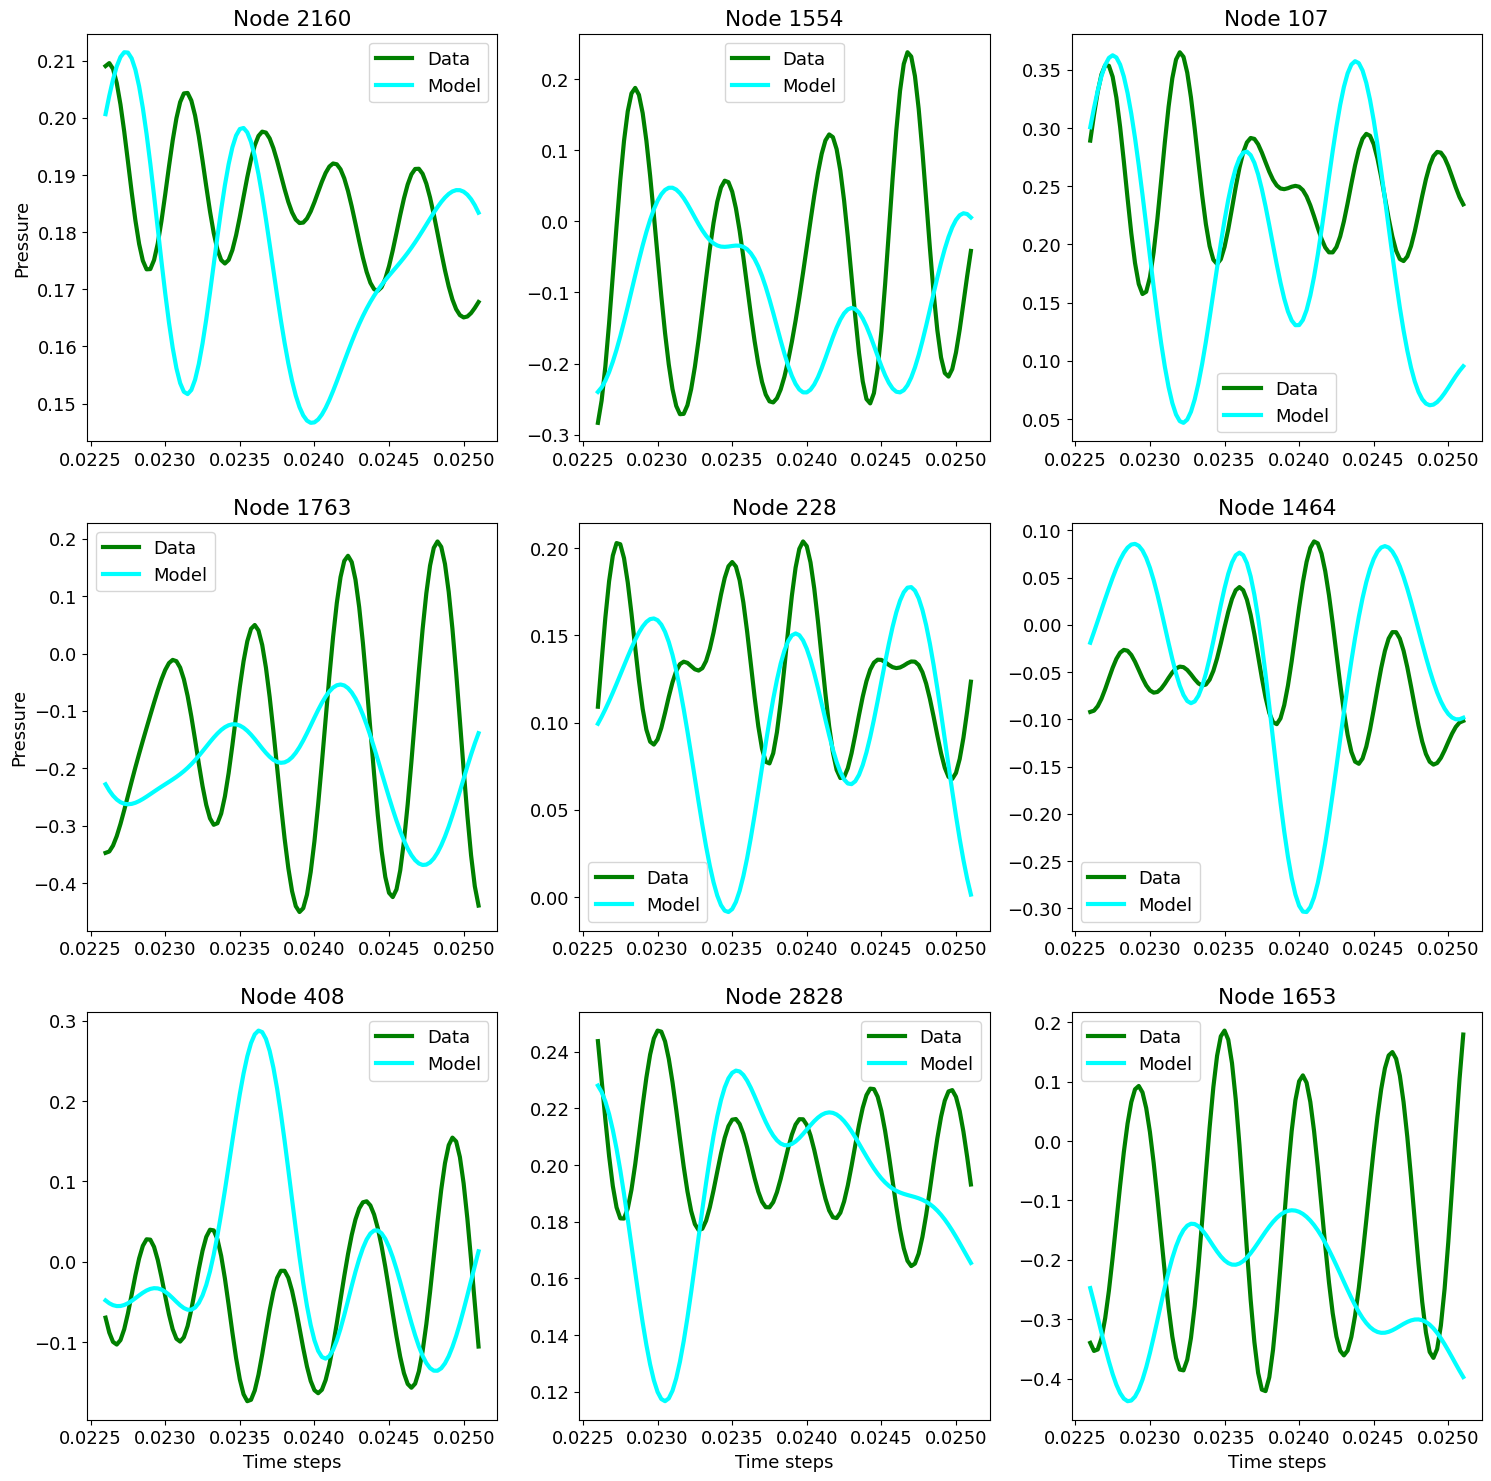

In [9]:
plt.rcParams['font.size'] = 13
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTest, opInfData[-timeTest.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTest, reconstructIntTest[-timeTest.shape[0]:, point],
    label = "Model", color = 'cyan', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time steps")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

### Reconstruction error
Sample some points and plot their reconstruction error histories in the train split

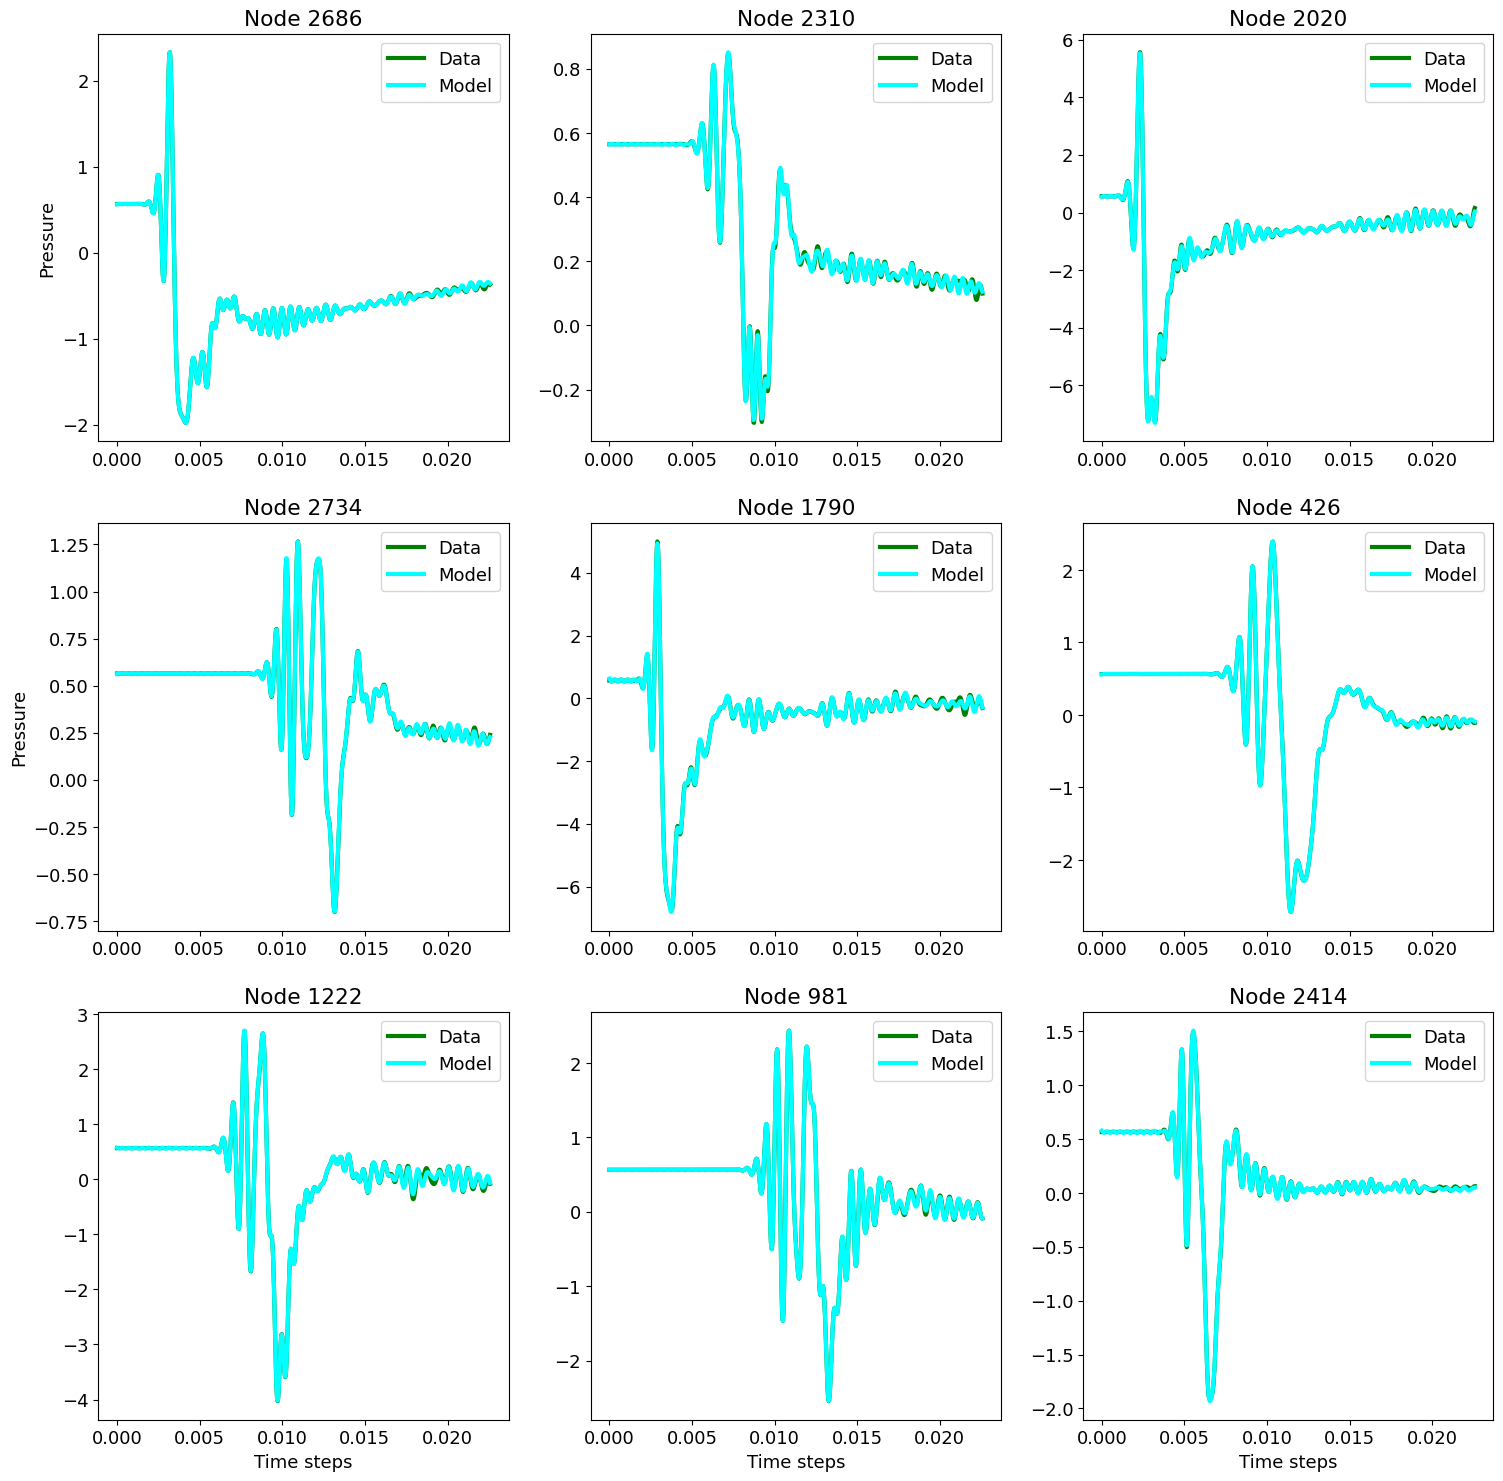

In [10]:
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTrain, opInfData[:timeTrain.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTrain, reconstructedData[:timeTrain.shape[0]:, point],
    label = "Model", color = 'cyan', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time steps")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

### Animation

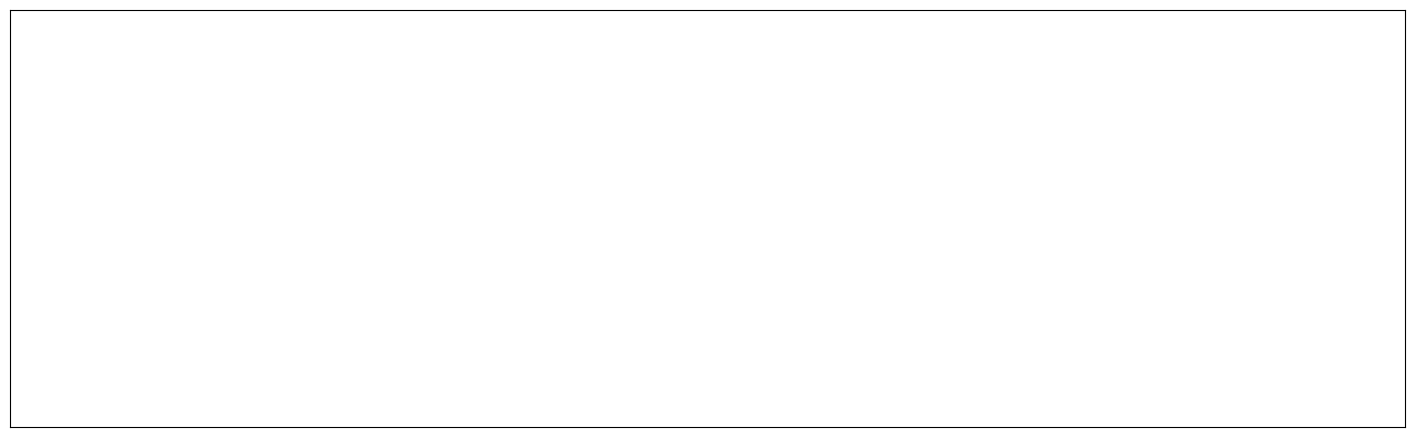

In [18]:
fig, ax = plt.subplots(figsize = (18, 18))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# im = ax.imshow(reconstructIntTest)
a = deepcopy(reconstructedData)

artists = []
for i in range(20):
  a[400:800, 1000:2000] = np.tile(np.sin(np.random.random() * 2 - 1), (400, 1000)) * 70
  con = ax.imshow(a)
  artists.append([con])


ani = animation.ArtistAnimation(fig = fig, artists = artists, interval  = 400, repeat = False)
ani.save(filename = "./animation/wavePropagation.gif", writer = "pillow");